In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('daily-minimum-temperatures-in-me.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df['Daily minimum temperatures'] = pd.to_numeric(df['Daily minimum temperatures'], errors='coerce')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        3650 non-null   datetime64[ns]
 1   Daily minimum temperatures  3647 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [6]:
df.isnull().sum()

Date                          0
Daily minimum temperatures    3
dtype: int64

In [7]:
df['Daily minimum temperatures'] = df['Daily minimum temperatures'].fillna(df['Daily minimum temperatures'].mean())

In [8]:
df.isnull().sum()

Date                          0
Daily minimum temperatures    0
dtype: int64

In [9]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')  # Adjust format if needed

In [10]:
df.set_index('Date', inplace=True)  # Set it as the index

In [11]:
df

,Daily minimum temperatures
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


In [12]:
df['Time_Difference'] = df.index.to_series().diff().dt.days
print(df['Time_Difference'].value_counts())  # Should now only show 1.0

Time_Difference
1.0    3647
2.0       2
Name: count, dtype: int64


In [13]:
df = df.asfreq('D')  # Enforce daily frequency
df.interpolate(method='linear', inplace=True)  # Fill missing values smoothly


In [14]:
df['Time_Difference'] = df.index.to_series().diff().dt.days
print(df['Time_Difference'].value_counts())  # Should now only show 1.0

Time_Difference
1.0    3651
Name: count, dtype: int64


In [15]:
df

,Daily minimum temperatures,Time_Difference
Date,,
1981-01-01,20.7,NaN
1981-01-02,17.9,1.0
1981-01-03,18.8,1.0
1981-01-04,14.6,1.0
1981-01-05,15.8,1.0
...,...,...
1990-12-27,14.0,1.0
1990-12-28,13.6,1.0
1990-12-29,13.5,1.0


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 0, 'to maike chodu')

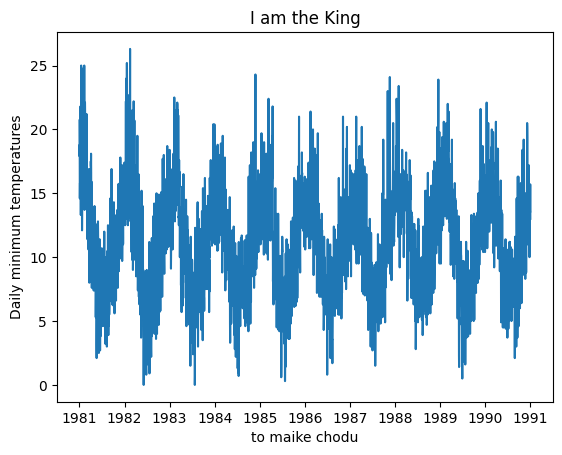

In [17]:
sns.lineplot(x=df.index, y=df['Daily minimum temperatures'], data = df)
plt.title ('I am the King')
plt.xlabel('to maike chodu')

In [18]:
df.isnull().sum()

Daily minimum temperatures    0
Time_Difference               1
dtype: int64

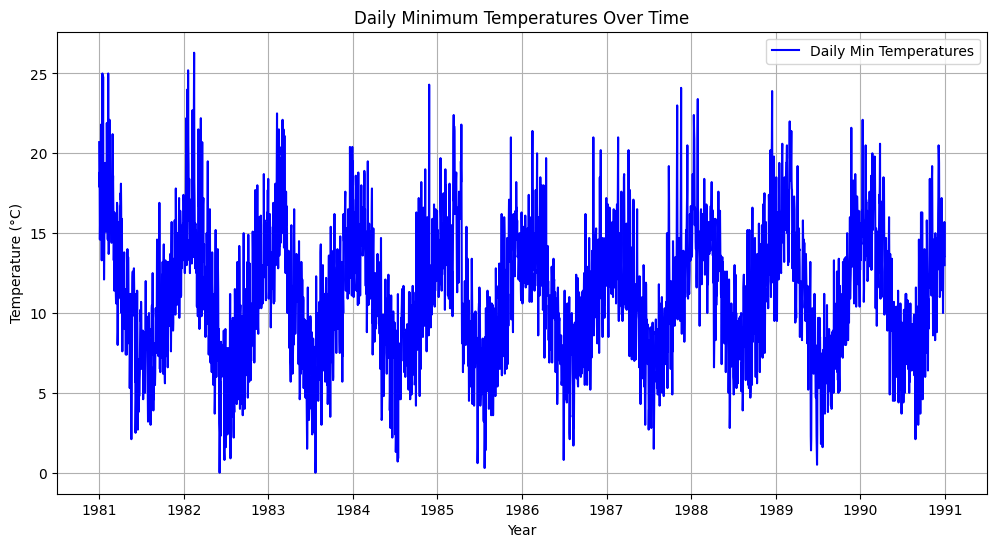

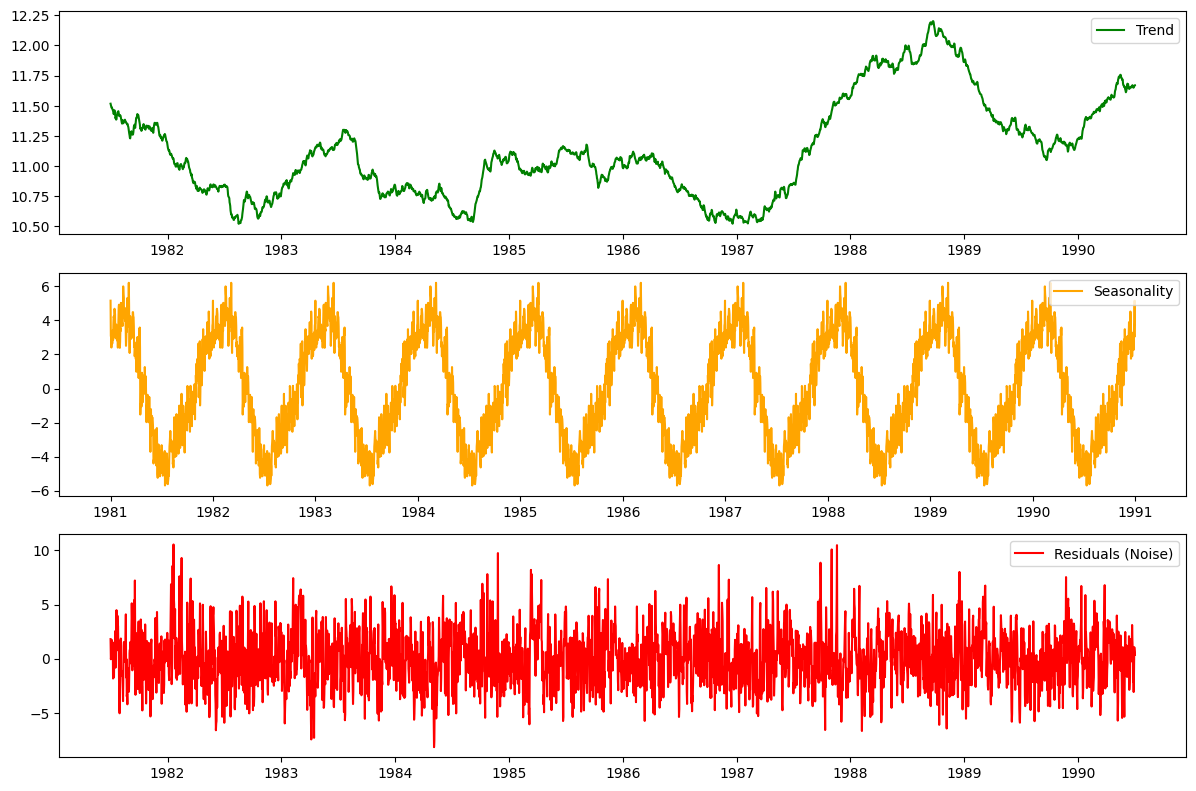

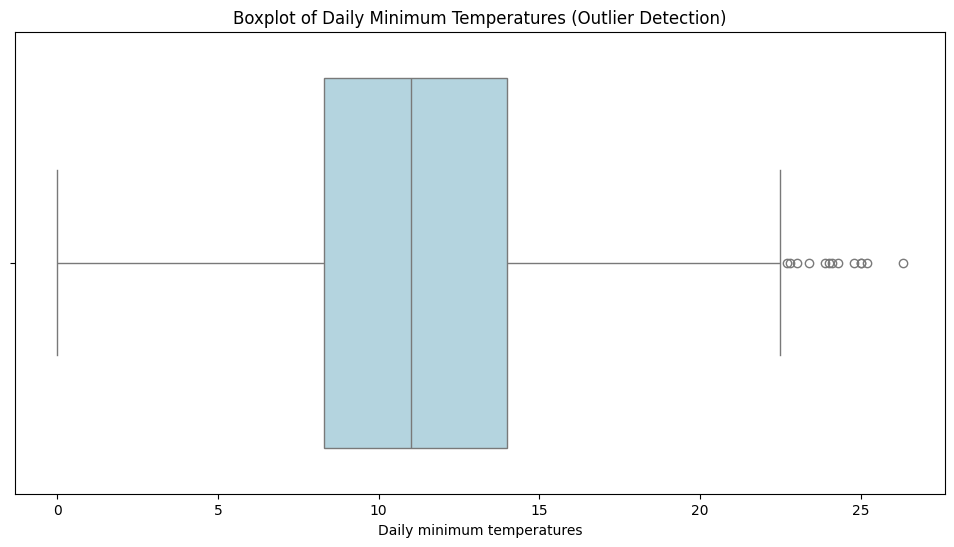

In [22]:

from statsmodels.tsa.seasonal import seasonal_decompose

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Daily minimum temperatures'], label='Daily Min Temperatures', color='blue')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Daily Minimum Temperatures Over Time')
plt.legend()
plt.grid()
plt.show()

# Time series decomposition (Trend, Seasonality, Residuals)
decomposition = seasonal_decompose(df['Daily minimum temperatures'], model='additive', period=365)

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label='Residuals (Noise)', color='red')
plt.legend()

plt.tight_layout()
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Daily minimum temperatures'], color='lightblue')
plt.title('Boxplot of Daily Minimum Temperatures (Outlier Detection)')
plt.show()

In [23]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Daily minimum temperatures'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("The time series is stationary (reject H0).")
else:
    print("The time series is NOT stationary (fail to reject H0). Consider differencing.")


ADF Statistic: -4.41854173365378
p-value: 0.0002751901922822466
The time series is stationary (reject H0).


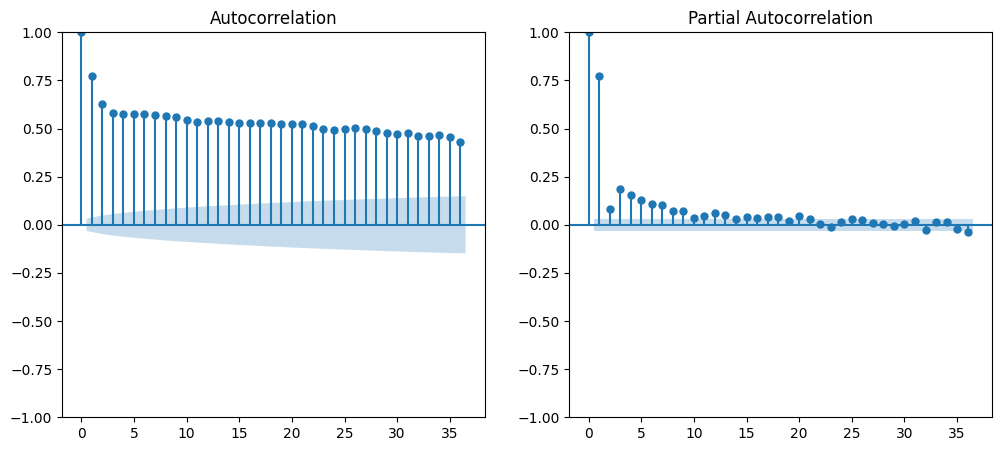

In [24]:
#Why? Helps determine lag values for ARIMA/other models.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Daily minimum temperatures'].dropna(), ax=ax[0])
plot_pacf(df['Daily minimum temperatures'].dropna(), ax=ax[1])
plt.show()


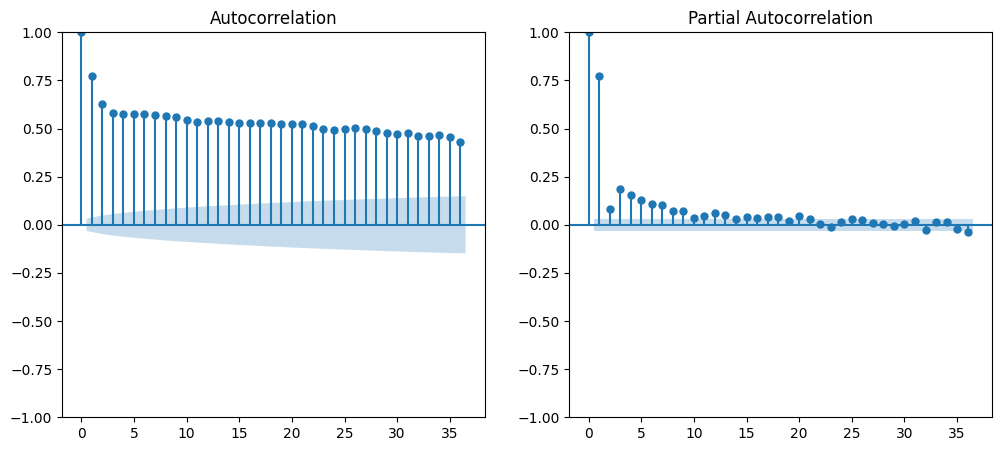

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure Date is the index and set frequency
df = df.asfreq('D')

# Plot ACF & PACF to determine p, q
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Daily minimum temperatures'].dropna(), ax=ax[0])
plot_pacf(df['Daily minimum temperatures'].dropna(), ax=ax[1])
plt.show()

# Fit SARIMA Model (p, d, q) x (P, D, Q, s)
model = SARIMAX(df['Daily minimum temperatures'],
                order=(2, 1, 2),   # (p, d, q)
                seasonal_order=(1, 1, 1, 365),  # (P, D, Q, m) - Yearly seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# Make Predictions
df['SARIMA_Predictions'] = model_fit.fittedvalues

# Plot Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Daily minimum temperatures'], label='Actual', color='blue')
plt.plot(df.index, df['SARIMA_Predictions'], label='SARIMA Predictions', color='red')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.title('SARIMA Model - Actual vs Predicted')
plt.show()

# Forecast Future Values (Next 30 Days)
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Plot Future Forecast
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Daily minimum temperatures'], label='Actual', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=forecast_steps, freq='D'),
         forecast, label='Forecast (Next 30 Days)', color='green')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.title('SARIMA Forecast for Next 30 Days')
plt.show()

# Evaluate Model
actual = df['Daily minimum temperatures'].dropna()
predicted = df['SARIMA_Predictions'].dropna()

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
